In [1]:
import pandas as pd
import numpy as np
import datetime 
from itertools import product

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
train = pd.read_csv('E:/2020Summer/machine learning/competitive-data-science-predict-future-sales/sales_train.csv')
test = pd.read_csv('E:/2020Summer/machine learning/competitive-data-science-predict-future-sales/test.csv')
submission = pd.read_csv('E:/2020Summer/machine learning/competitive-data-science-predict-future-sales/sample_submission.csv')
items = pd.read_csv('E:/2020Summer/machine learning/competitive-data-science-predict-future-sales/items.csv')
item_cats = pd.read_csv('E:/2020Summer/machine learning/competitive-data-science-predict-future-sales/item_categories.csv')
shops = pd.read_csv('E:/2020Summer/machine learning/competitive-data-science-predict-future-sales/shops.csv')

## Handling data in train

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
date              object
date_block_num    int64
shop_id           int64
item_id           int64
item_price        float64
item_cnt_day      float64
dtypes: float64(2), int64(3), object(1)
memory usage: 134.4+ MB


### For 'item_cnt_day'

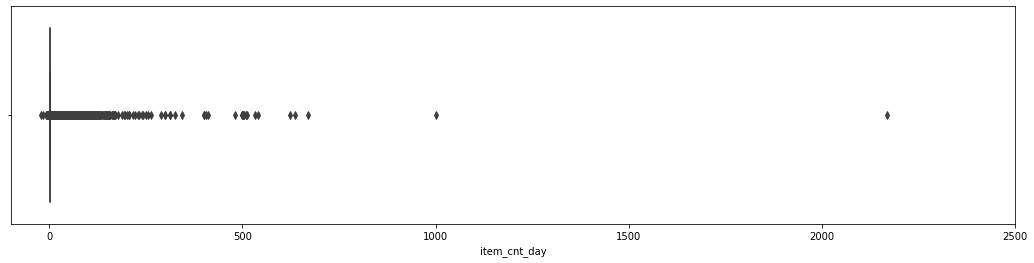

In [6]:
plt.figure(figsize=(18,4))
plt.xlim(-100,2500)
sns.boxplot(train['item_cnt_day'])

Delete some observations due to their higher item_cnt_day

In [7]:
train.loc[train['item_cnt_day']>900]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
2326930,15.01.2015,24,12,20949,4.000000,1000.0
2909818,28.10.2015,33,12,11373,0.908714,2169.0


Some item's per-day sale is negative. This item might be lost,stolen or due to some other reasons happened that day. Therefore, these values cannot be regarded as sales.

In [8]:
train.loc[train['item_cnt_day']<-5]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
59156,18.01.2013,0,12,1590,2599.000000,-6.0
940092,19.10.2013,9,42,3732,2599.000000,-6.0
1057907,02.11.2013,10,12,8023,15.000000,-22.0
1835454,10.07.2014,18,14,20949,5.000000,-16.0
2048519,10.10.2014,21,12,9242,1433.333333,-9.0


In [9]:
indexvalue = train.loc[(train['item_cnt_day']<-5)|(train['item_cnt_day']>900)].index.values
train = train.drop(train.index[indexvalue])

### For 'item_price'

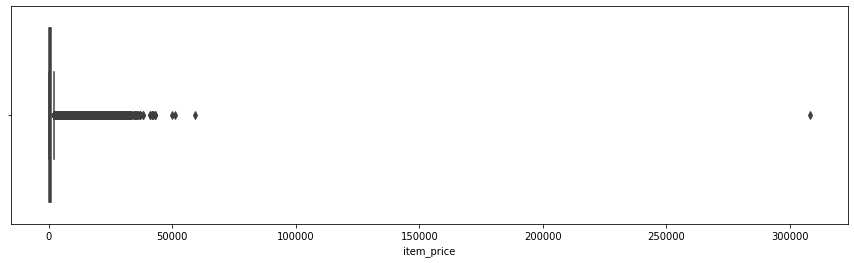

In [10]:
plt.figure(figsize=(15,4))
sns.boxplot(train['item_price'])

Only one item's price is too high in this dataset. This is abnormal.

In [11]:
train.loc[train['item_price']>250000]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
1163158,13.12.2013,11,12,6066,307980.0,1.0


In [12]:
train = train.drop(train.index[1163158])

Also one item's price is negative. So we can replace this price using this item's mean or median.

In [13]:
train.loc[train['item_price']<0]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
484683,15.05.2013,4,32,2973,-1.0,1.0


In [14]:
val_mean = train[train['item_id']==2973].item_price.mean()

In [15]:
train.loc[train['item_price']<0,'item_price'] = val_mean

Define a function to transform some column's type in order to save memory usage

In [16]:
def downcast_dtypes(df):
    cols_float64 = [c for c in df if df[c].dtype == 'float64']
    cols_int64_32 = [c for c in df if df[c].dtype in ['int64', 'int32']]
    df[cols_float64] = df[cols_float64].astype(np.float32)
    df[cols_int64_32] = df[cols_int64_32].astype(np.int16)
    return df

In [17]:
train = downcast_dtypes(train)
test = downcast_dtypes(test)

In [18]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2935841 entries, 0 to 2935848
Data columns (total 6 columns):
date              object
date_block_num    int16
shop_id           int16
item_id           int16
item_price        float32
item_cnt_day      float32
dtypes: float32(2), int16(3), object(1)
memory usage: 84.0+ MB


### Create a column to calculate each shop's each item's revenue

In [19]:
train['revenue'] = train['item_price'] * train['item_cnt_day']

### Obtain the information about `shop's` status

In [20]:
s3 = train.pivot_table(index=['shop_id'],values=['item_cnt_day'], 
                  columns='date_block_num', aggfunc=np.sum, fill_value=0).reset_index()

As we can see from the table below, for some shop, the 'item_cnt_day' is 0 in some date_block_num:
* shop_id: 0, 1, 8, 9,13, 17, 23, 30, 32, 33, 34, 40, 43, 44, 51, 54 <br>

Then we can assume that these shop might be closed, whether it is temporarily or permanently we are not sure. Therefore we need to compare with the test set to decide wheter we need to delete these shop's information or keep them.

In [21]:
s3.style.background_gradient(cmap='Blues')

In [22]:
list(sorted(set(train.shop_id.unique()) - set(test.shop_id.unique())))

[0, 1, 8, 9, 11, 13, 17, 20, 23, 27, 29, 30, 32, 33, 40, 43, 51, 54]

Besides, there are some shops in train but not in test set.
* shop_id in train but not in test : `0, 1, 8, 9, 11, 13, 17, 20, 23, 27, 29, 30, 32, 33, 40, 43, 51, 54`
* shop we assume it is closed: `0, 1, 8, 9, 11, 13, 17, 23, 30, 32, 33, 34, 40, 43, 44, 51, 54`

In [23]:
train[(train['shop_id']==0)|(train['shop_id']==1)|(train['shop_id']==8)|(train['shop_id']==9)|(train['shop_id']==11)|(train['shop_id']==13)|(train['shop_id']==17)|(train['shop_id']==23)|(train['shop_id']==30)|
     (train['shop_id']==32)|(train['shop_id']==33)|(train['shop_id']==34)|(train['shop_id']==40)|(train['shop_id']==43)|(train['shop_id']==44)|(train['shop_id']==51)|(train['shop_id']==54)]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,revenue
2466,15.01.2013,0,23,21567,379.0,1.0,379.0
2467,06.01.2013,0,23,21570,199.0,1.0,199.0
2468,05.01.2013,0,23,21771,449.5,1.0,449.5
2469,10.01.2013,0,23,21771,899.0,1.0,899.0
2470,23.01.2013,0,23,21619,499.0,1.0,499.0
...,...,...,...,...,...,...,...
2919696,02.10.2015,33,9,21950,1699.0,6.0,10194.0
2919697,01.10.2015,33,9,21951,1699.0,2.0,3398.0
2919698,04.10.2015,33,9,21951,1699.0,4.0,6796.0
2919699,01.10.2015,33,9,21954,1599.0,3.0,4797.0


In [24]:
inds = train[(train['shop_id']==0)|(train['shop_id']==1)|(train['shop_id']==8)|(train['shop_id']==9)|(train['shop_id']==11)|(train['shop_id']==13)|(train['shop_id']==17)|(train['shop_id']==23)|(train['shop_id']==30)|
     (train['shop_id']==32)|(train['shop_id']==33)|(train['shop_id']==34)|(train['shop_id']==40)|(train['shop_id']==43)|(train['shop_id']==44)|(train['shop_id']==51)|(train['shop_id']==54)].index

In [25]:
train = train.drop(inds)

### Obtain the information about `item's` status

In [26]:
print(len(list(sorted(set(test.item_id.unique()) - set(train.item_id.unique())))))
print(len(list(sorted(set(train.item_id.unique()) - set(test.item_id.unique())))))

372
16393


There are `363` items in test but not in train, and `17,070` items in train but not in test. It might be difficult to forecast sales of the items in test but not in train.

## Handling data in shops

In [27]:
shops.head(5)

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


Add city column from "shop_name" and encode this column.

In [28]:
shops['city'] = shops['shop_name'].apply(lambda x: x.split(" ")[0])

In [29]:
shops['city'] = shops['city'].apply(lambda x: x.lower())

In [30]:
from sklearn.preprocessing import LabelEncoder

In [31]:
encoder = LabelEncoder()

In [32]:
shops['city_code'] = encoder.fit_transform(shops['city'])

In [33]:
shops = shops[['shop_id','city_code']]

## Handling data in item_category

In [34]:
item_cats.head(5)

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [35]:
item_cats['first_split'] = item_cats.item_category_name.apply(lambda x: x.split(" - "))

In [36]:
item_cats['type'] = item_cats['first_split'].apply(lambda x: x[0])

In [37]:
item_cats['product'] = item_cats['first_split'].apply(lambda x: x[1] if len(x) > 1 else x[0])

In [38]:
item_cats['type_code'] = encoder.fit_transform(item_cats['type'])

In [39]:
item_cats['product_code'] = encoder.fit_transform(item_cats['product'])

In [40]:
item_cats2 = item_cats[['item_category_id','type_code','product_code']]

## Merging files

In [41]:
whole=[]

for i in range(0,34):
    shops_month=train.loc[train['date_block_num']==i,'shop_id'].unique()
    items_month=train.loc[train['date_block_num']==i,'item_id'].unique()
    whole.append(np.array(list(product([i],shops_month,items_month))))
    
whole=np.vstack(whole)
whole=pd.DataFrame(whole,columns=['date_block_num','shop_id','item_id'])

In [42]:
whole.head(5)

,date_block_num,shop_id,item_id
0,0,59,22154
1,0,59,2552
2,0,59,2554
3,0,59,2555
4,0,59,2564


In [43]:
test['date_block_num']=34
test=test[['date_block_num','shop_id','item_id']]
whole=pd.concat([whole,test],axis=0)

In [44]:
whole.head(5)

,date_block_num,shop_id,item_id
0,0,59,22154
1,0,59,2552
2,0,59,2554
3,0,59,2555
4,0,59,2564


Calculate each item's monthly sale in each shop

In [45]:
sale = train.groupby(['date_block_num','shop_id','item_id']).agg({'item_cnt_day':['sum']})
sale.columns = ['item_cnt_month']
sale.reset_index(inplace=True)
sale['item_cnt_month'] = (sale['item_cnt_month'].clip(0,20).astype(np.float))

In [46]:
sale.head(5)

,date_block_num,shop_id,item_id,item_cnt_month
0,0,2,27,1.0
1,0,2,33,1.0
2,0,2,317,1.0
3,0,2,438,1.0
4,0,2,471,2.0


In [47]:
whole = whole.merge(sale,how='left',on = ['date_block_num','shop_id','item_id'])
whole = whole.merge(shops,how='left',on='shop_id')
whole = whole.merge(items,how='left',on='item_id')
whole = whole.merge(item_cats2,how='left',on='item_category_id')

In [48]:
whole.head(3)

,date_block_num,shop_id,item_id,item_cnt_month,city_code,item_name,item_category_id,type_code,product_code
0,0,59,22154,1.0,31,ЯВЛЕНИЕ 2012 (BD),37,11,1
1,0,59,2552,NaN,31,DEEP PURPLE The House Of Blue Light LP,58,13,29
2,0,59,2554,NaN,31,DEEP PURPLE Who Do You Think We Are LP,58,13,29


Set month and year

In [49]:
def year_value(sd):
    if 0<=sd<=12:
        return 0
    elif 13<=sd<=24:
        return 1
    else:
        return 2

In [50]:
whole['month'] = whole['date_block_num'].apply(lambda x: x%12)

In [51]:
whole['year'] = whole['date_block_num'].apply(lambda x: year_value(x))

In [52]:
whole.head(5)

,date_block_num,shop_id,item_id,item_cnt_month,city_code,item_name,item_category_id,type_code,product_code,month,year
0,0,59,22154,1.0,31,ЯВЛЕНИЕ 2012 (BD),37,11,1,0,0
1,0,59,2552,NaN,31,DEEP PURPLE The House Of Blue Light LP,58,13,29,0,0
2,0,59,2554,NaN,31,DEEP PURPLE Who Do You Think We Are LP,58,13,29,0,0
3,0,59,2555,NaN,31,DEEP PURPLE 30 Very Best Of 2CD (Фирм.),56,13,5,0,0
4,0,59,2564,NaN,31,DEEP PURPLE Perihelion: Live In Concert DVD (К...,59,13,42,0,0


## Adding more features 

In [53]:
whole2 = whole.copy()

In [54]:
whole2 = whole2.drop(['item_name'],axis=1)

### Every shop's average cnt

In [55]:
cnt_mean = whole.query("date_block_num<34").groupby("shop_id").agg({"item_cnt_month":["mean"]})

In [56]:
cnt_mean.columns = ['shop_id_mean']
whole2['shop_id_mean'] = whole2['shop_id'].map(cnt_mean['shop_id_mean'])

### every item's average count

In [57]:
item_mean = whole.query("date_block_num<34").groupby("item_id").agg({"item_cnt_month":["mean"]})

In [58]:
item_mean.columns = ['item_cnt_month']

In [59]:
whole2['item_cnt_mean'] = whole2['item_id'].map(item_mean['item_cnt_month'])

### every category's average count

In [60]:
c = whole.query("date_block_num<34").groupby("item_category_id").agg({"item_cnt_month":["mean"]})

In [61]:
c.columns = ['category_mean']

In [62]:
whole2['category_mean'] = whole['item_category_id'].map(c['category_mean'])

### Every item's mean price

In [63]:
item_pr =  train.query("date_block_num<34").groupby("item_id").agg({"item_price":["mean"]})

In [64]:
item_pr.columns = ['item_mean_price']

In [65]:
whole2['item_mean_price'] = whole2['item_id'].map(item_pr['item_mean_price'])

In [66]:
whole2 = downcast_dtypes(whole2)

## Adding date_item_mean lag features

In [67]:
whole2.head(3)

,date_block_num,shop_id,item_id,item_cnt_month,city_code,item_category_id,type_code,product_code,month,year,shop_id_mean,item_cnt_mean,category_mean,item_mean_price
0,0,59,22154,1.0,31,37,11,1,0,0,1.84367,1.139535,1.505574,670.428589
1,0,59,2552,NaN,31,58,13,29,0,0,1.84367,0.714286,1.117337,936.500000
2,0,59,2554,NaN,31,58,13,29,0,0,1.84367,1.000000,1.117337,1709.050049


In [68]:
date_item_mean = whole2.query("date_block_num<34").groupby(["date_block_num","item_id"]).agg({"item_cnt_month":["mean"]})

In [69]:
date_item_mean.columns = ['date_item_cnt_mean']
whole2 = whole2.merge(date_item_mean,on=['date_block_num','item_id'],how='left')

In [70]:
date_item_mean = date_item_mean.reset_index()

### date_item_cnt_mean_lag1

In [71]:
# date_item_mean['date_block_num']=date_item_mean['date_block_num']+1

In [72]:
# date_item_mean.columns = ['date_block_num', 'item_id', 'date_item_cnt_mean_lag1']

In [88]:
# whole2 = whole2.merge(date_item_mean,how='left',on=['date_block_num','item_id'])

### date_item_cnt_mean_lag2

In [89]:
# date_item_mean['date_block_num']=date_item_mean['date_block_num']+1

In [90]:
# date_item_mean.columns = ['date_block_num', 'item_id', 'date_item_cnt_mean_lag2']

In [91]:
# whole2 = whole2.merge(date_item_mean,how='left',on=['date_block_num','item_id'])

### date_item_cnt_mean_lag3

In [92]:
# date_item_mean['date_block_num']=date_item_mean['date_block_num']+1

In [93]:
# date_item_mean.columns = ['date_block_num', 'item_id', 'date_item_cnt_mean_lag3']

In [94]:
# whole2 = whole2.merge(date_item_mean,how='left',on=['date_block_num','item_id'])

## Adding date_shop_cnt_mean_lag features

In [73]:
date_shop_mean = whole2.query("date_block_num<34").groupby(["date_block_num","shop_id"]).agg({"item_cnt_month":["mean"]})

In [74]:
date_shop_mean.columns = ['date_shop_cnt_mean']
date_shop_mean = date_shop_mean.reset_index()

In [75]:
date_shop_mean.head(5)

,date_block_num,shop_id,date_shop_cnt_mean
0,0,2,1.574176
1,0,3,1.409926
2,0,4,1.967043
3,0,6,1.909383
4,0,7,1.952793


In [76]:
whole2 = pd.merge(whole2,date_shop_mean,on=['date_block_num','shop_id'],how='left')

###  Adding date_shop_cnt_mean_lag1 features

In [83]:
# date_shop_mean['date_block_num'] = date_shop_mean['date_block_num'] + 1

In [84]:
# date_shop_mean.columns = ['date_block_num', 'item_id', 'date_shop_cnt_mean_lag1']

In [85]:
# whole2 = whole2.merge(date_shop_mean,how='left',on=['date_block_num','item_id'])

###  Adding date_shop_cnt_mean_lag2 features

In [86]:
# date_shop_mean['date_block_num'] = date_shop_mean['date_block_num'] + 1

In [87]:
# date_shop_mean.columns = ['date_block_num', 'item_id', 'date_shop_cnt_mean_lag2']

In [88]:
# whole2 = pd.merge(whole2,date_shop_mean,how='left',on=['date_block_num','item_id'])

###  Adding date_shop_cnt_mean_lag3 features

In [89]:
# date_shop_mean['date_block_num'] = date_shop_mean['date_block_num'] + 1

In [90]:
# date_shop_mean.columns = ['date_block_num', 'item_id', 'date_shop_cnt_mean_lag3']

In [91]:
# whole2 = pd.merge(whole2,date_shop_mean,how='left',on=['date_block_num','item_id'])

## Adding date_shop_revenue_sum feature

In [77]:
date_shop_rev = train.query('date_block_num<34').groupby(['date_block_num','shop_id']).agg({'revenue':['sum']})

In [78]:
date_shop_rev.columns = ['date_shop_rev']

In [79]:
date_shop_rev = date_shop_rev.reset_index()

In [80]:
whole2= pd.merge(whole2,date_shop_rev,on=['date_block_num','shop_id'],how='left')

### Adding date_shop_revenue_mean_lag1

In [103]:
# date_shop_rev['date_block_num'] = date_shop_rev['date_block_num']+1

In [104]:
# date_shop_rev.columns = ['date_block_num', 'shop_id', 'date_shop_rev_lag1']

In [105]:
# whole2 = pd.merge(whole2,date_shop_rev,on=['date_block_num','shop_id'],how='left')

### Adding date_shop_revenue_mean_lag2

In [106]:
# date_shop_rev['date_block_num'] = date_shop_rev['date_block_num']+1

In [107]:
# date_shop_rev.columns = ['date_block_num', 'shop_id', 'date_shop_rev_lag2']

In [108]:
# whole2 = pd.merge(whole2,date_shop_rev,on=['date_block_num','shop_id'],how='left')

## Adding date_shop_revenue_mean_lag3

In [109]:
# date_shop_rev['date_block_num'] = date_shop_rev['date_block_num']+1

In [110]:
# date_shop_rev.columns = ['date_block_num', 'shop_id', 'date_shop_rev_lag3']

In [111]:
# whole2 = pd.merge(whole2,date_shop_rev,on=['date_block_num','shop_id'],how='left')

In [105]:
whole2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8976147 entries, 0 to 8976146
Data columns (total 26 columns):
date_block_num               int16
shop_id                      int16
item_id                      int16
item_cnt_month               float32
city_code                    int16
item_category_id             int16
type_code                    int16
product_code                 int16
month                        int16
year                         int16
shop_id_mean                 float32
item_cnt_mean                float32
category_mean                float32
item_mean_price              float32
date_item_cnt_mean           float32
date_item_cnt_mean_lag1      float32
date_item_cnt_mean_lag2      float32
date_item_cnt_mean_lag3      float32
date_shop_cnt_mean           float32
date_shop_cnt_mean_lag1      float32
date_shop_cnt_mean_lag2_x    float32
date_shop_cnt_mean_lag2_y    float32
date_shop_rev                float32
date_shop_rev_lag1           float32
date_shop_rev_lag

In [81]:
whole3 = whole2.fillna(0)

In [82]:
whole3.head(3)

,date_block_num,shop_id,item_id,item_cnt_month,city_code,item_category_id,type_code,product_code,month,year,shop_id_mean,item_cnt_mean,category_mean,item_mean_price,date_item_cnt_mean,date_shop_cnt_mean,date_shop_rev
0,0,59,22154,1.0,31,37,11,1,0,0,1.84367,1.139535,1.505574,670.428589,1.333333,1.893195,1633431.0
1,0,59,2552,0.0,31,58,13,29,0,0,1.84367,0.714286,1.117337,936.500000,0.000000,1.893195,1633431.0
2,0,59,2554,0.0,31,58,13,29,0,0,1.84367,1.000000,1.117337,1709.050049,1.000000,1.893195,1633431.0


In [83]:
whole3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8976147 entries, 0 to 8976146
Data columns (total 17 columns):
date_block_num        int16
shop_id               int16
item_id               int16
item_cnt_month        float32
city_code             int16
item_category_id      int16
type_code             int16
product_code          int16
month                 int16
year                  int16
shop_id_mean          float32
item_cnt_mean         float32
category_mean         float32
item_mean_price       float32
date_item_cnt_mean    float32
date_shop_cnt_mean    float32
date_shop_rev         float32
dtypes: float32(8), int16(9)
memory usage: 496.5 MB


In [131]:
# whole3['shop_id'] = whole3['shop_id'].astype("int16")

In [132]:
# whole3['item_id'] = whole3['item_id'].astype("int16")

In [133]:
# whole3['city_code'] = whole3['city_code'].astype("int16")

In [134]:
# whole3['item_category_id'] = whole3['item_category_id'].astype("int16")

In [135]:
# whole3['type_code'] = whole3['type_code'].astype("int16")

In [136]:
# whole3['product_code'] = whole3['product_code'].astype('int16')

In [57]:
whole3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8976147 entries, 0 to 8976146
Data columns (total 16 columns):
date_block_num        int16
shop_id               int16
item_id               int16
item_cnt_month        float32
city_code             int16
item_category_id      int16
type_code             int16
product_code          int16
month                 int16
year                  int16
shop_id_mean          float32
item_cnt_mean         float32
category_mean         float32
item_mean_price       float32
date_item_cnt_mean    float32
date_shop_cnt_mean    float32
dtypes: float32(7), int16(9)
memory usage: 462.3 MB


## Getting onehotencoder

In [84]:
whole4 = whole3.transpose()

In [85]:
onehot = pd.DataFrame(pd.get_dummies(whole3.shop_id, prefix='shop_id')).transpose()

In [86]:
whole5 = whole4.append(onehot)

In [87]:
whole5 = whole5.transpose()

In [88]:
whole5.head()

,date_block_num,shop_id,item_id,item_cnt_month,city_code,item_category_id,type_code,product_code,month,year,...,shop_id_48,shop_id_49,shop_id_50,shop_id_52,shop_id_53,shop_id_55,shop_id_56,shop_id_57,shop_id_58,shop_id_59
0,0.0,59.0,22154.0,1.0,31.0,37.0,11.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.0,59.0,2552.0,0.0,31.0,58.0,13.0,29.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,59.0,2554.0,0.0,31.0,58.0,13.0,29.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.0,59.0,2555.0,0.0,31.0,56.0,13.0,5.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.0,59.0,2564.0,0.0,31.0,59.0,13.0,42.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [89]:
X_train=whole5.drop("item_cnt_month",axis=1).query("date_block_num<33")
y_train=whole5.query("date_block_num<33")["item_cnt_month"]
X_val=whole5.drop("item_cnt_month",axis=1).query("date_block_num==33")
y_val=whole5.query("date_block_num==33")["item_cnt_month"]
X_test=whole5.drop("item_cnt_month",axis=1).query("date_block_num==34")

In [90]:
import lightgbm as lgb

ModuleNotFoundError: No module named 'lightgbm'

In [ ]:
lgb_train = lgb.Dataset(X_train,y_train)
lgb_eval = lgb.Dataset(X_val,y_val,reference=lgb_train)

In [ ]:
params = {
        'task': 'train',
        'boosting_type': 'gbdt',
        'objective': 'regression',
        'metric': {'rmse'},
        'learning_rate': 0.3,
        'num_leaves': 30,
        'min_data_in_leaf': 1,
        'num_iteration': 250,
        'verbose': 20
}

In [174]:
gbm = lgb.train(params,
            lgb_train,
            num_boost_round=1000,
            valid_sets=lgb_eval,
            early_stopping_rounds=10,
            categorical_feature=['shop_id','item_id','item_category_id','type_code','product_code'])

/Users/liziwei/opt/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1295: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['item_category_id', 'item_id', 'product_code', 'shop_id', 'type_code']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


[1]	valid_0's rmse: 0.973061
Training until validation scores don't improve for 10 rounds
[2]	valid_0's rmse: 0.885099
[3]	valid_0's rmse: 0.834512
[4]	valid_0's rmse: 0.80871
[5]	valid_0's rmse: 0.790008
[6]	valid_0's rmse: 0.77517
[7]	valid_0's rmse: 0.761262
[8]	valid_0's rmse: 0.753981
[9]	valid_0's rmse: 0.747283
[10]	valid_0's rmse: 0.743787
[11]	valid_0's rmse: 0.738526
[12]	valid_0's rmse: 0.735996
[13]	valid_0's rmse: 0.732822
[14]	valid_0's rmse: 0.731645
[15]	valid_0's rmse: 0.729557
[16]	valid_0's rmse: 0.729502
[17]	valid_0's rmse: 0.726543
[18]	valid_0's rmse: 0.724846
[19]	valid_0's rmse: 0.722366
[20]	valid_0's rmse: 0.718245
[21]	valid_0's rmse: 0.717817
[22]	valid_0's rmse: 0.716718
[23]	valid_0's rmse: 0.716203
[24]	valid_0's rmse: 0.715267
[25]	valid_0's rmse: 0.712673
[26]	valid_0's rmse: 0.711439
[27]	valid_0's rmse: 0.711218
[28]	valid_0's rmse: 0.710514
[29]	valid_0's rmse: 0.709865
[30]	valid_0's rmse: 0.70535
[31]	valid_0's rmse: 0.70539
[32]	valid_0's rmse: 0

In [146]:
te2 = pd.read_csv("test.csv")

In [175]:
y_test = gbm.predict(X_test)

In [176]:
fin = pd.DataFrame({"ID":te2.ID.values,
              "item_cnt_month":y_test})

In [177]:
fin.to_csv("sub2.csv",index=False)

<Figure size 5760x1152 with 0 Axes>

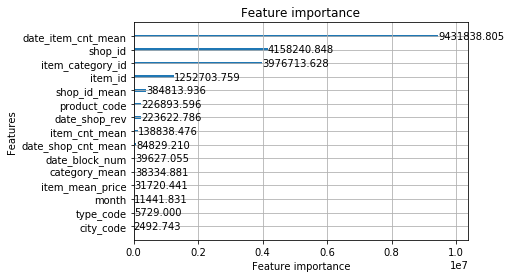

In [166]:
plt.figure(figsize=(80,16))
lgb.plot_importance(gbm, importance_type='gain')

In [ ]:
# whole3 = whole2.drop(['shop_name','item_name','item_category_name'],axis=1)

,date_block_num,shop_id,item_id,item_cnt_month,city_code,item_category_id,month,year,shop_id_mean,item_cnt_mean,category_mean,item_mean_price,date_item_cnt_mean,date_item_cnt_mean_lag1,date_shop_cnt_mean,date_shop_cnt_mean_lag1,date_shop_rev,date_shop_rev_lag1
0,0,59,22154,1.0,31,37,0,0,1.849464,1.134615,1.507444,702.932190,1.285714,0.0,1.903318,0.0,1645059.0,1.0
1,0,59,2552,0.0,31,58,0,0,1.849464,1.000000,1.126046,941.857117,1.000000,0.0,1.903318,0.0,1645059.0,1.0
2,0,59,2554,0.0,31,58,0,0,1.849464,1.000000,1.126046,1709.050049,1.000000,0.0,1.903318,0.0,1645059.0,1.0
3,0,59,2555,0.0,31,56,0,0,1.849464,1.056604,1.335173,1123.101807,1.000000,0.0,1.903318,0.0,1645059.0,1.0
4,0,59,2564,0.0,31,59,0,0,1.849464,1.121951,1.158373,340.152161,1.000000,0.0,1.903318,0.0,1645059.0,1.0


In [91]:
from xgboost import XGBRegressor
from xgboost import plot_importance

In [92]:
model = XGBRegressor(
    max_depth=8,
    n_estimators=1000,
    min_child_weight=300, 
    colsample_bytree=0.8, 
    subsample=0.8, 
    eta=0.3,    
    seed=42)

In [95]:
model.fit(
    X_train, 
    y_train, 
    eval_metric="rmse", 
    eval_set=[(X_train, y_train), (X_val, y_val)], 
    verbose=True, 
    early_stopping_rounds = 100)

MemoryError: 

In [139]:
y_test_pred = model.predict(X_test)

In [142]:
y_test_pred[y_test_pred<0] = 0

In [147]:
test = pd.read_csv("test.csv")

In [149]:
y_test_pred

array([0.12497577, 0.        , 0.07926375, ..., 0.02387992, 0.04595241,
       0.02164969], dtype=float32)

In [154]:
sub = pd.DataFrame({"ID" : test.ID.values,
            "item_cnt_month" : y_test_pred})

In [156]:
sub.to_csv("sub_xgb.csv")

## Time series

In [97]:
whole2.head(3)

,date_block_num,shop_id,item_id,item_cnt_month,city_code,item_category_id,month,year,shop_id_mean,item_cnt_mean,category_mean,item_mean_price,date_item_cnt_mean,date_item_cnt_mean_lag1,date_shop_cnt_mean,date_shop_cnt_mean_lag1,date_shop_rev,date_shop_rev_lag1
0,0,59,22154,1.0,31,37,0,0,1.849464,1.134615,1.507444,702.932190,1.285714,NaN,1.903318,NaN,1645059.0,1.0
1,0,59,2552,NaN,31,58,0,0,1.849464,1.000000,1.126046,941.857117,1.000000,NaN,1.903318,NaN,1645059.0,1.0
2,0,59,2554,NaN,31,58,0,0,1.849464,1.000000,1.126046,1709.050049,1.000000,NaN,1.903318,NaN,1645059.0,1.0


In [99]:
train.head(3)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,revenue
0,02.01.2013,0,59,22154,999.000000,1.0,999.000000
1,03.01.2013,0,25,2552,899.000000,1.0,899.000000
3,06.01.2013,0,25,2554,1709.050049,1.0,1709.050049


In [100]:
whole21 = whole2[['date_block_num','shop_id','item_id','item_category_id','shop_id_mean','item_cnt_mean','category_mean']]

In [101]:
whole21.head()

,date_block_num,shop_id,item_id,item_category_id,shop_id_mean,item_cnt_mean,category_mean
0,0,59,22154,37,1.849464,1.134615,1.507444
1,0,59,2552,58,1.849464,1.000000,1.126046
2,0,59,2554,58,1.849464,1.000000,1.126046
3,0,59,2555,56,1.849464,1.056604,1.335173
4,0,59,2564,59,1.849464,1.121951,1.158373


In [104]:
train11 = train[['date','date_block_num','shop_id','item_id','item_cnt_day']]

,date,date_block_num,shop_id,item_id,item_cnt_day
0,02.01.2013,0,59,22154,1.0
1,03.01.2013,0,25,2552,1.0
3,06.01.2013,0,25,2554,1.0


In [108]:
tsdf = pd.merge(train11,whole21,on=['date_block_num','shop_id','item_id'])

In [ ]:
import 

In [109]:
tsdf.head(5)

,date,date_block_num,shop_id,item_id,item_cnt_day,item_category_id,shop_id_mean,item_cnt_mean,category_mean
0,02.01.2013,0,59,22154,1.0,37,1.849464,1.134615,1.507444
1,03.01.2013,0,25,2552,1.0,58,2.366739,1.000000,1.126046
2,06.01.2013,0,25,2554,1.0,58,2.366739,1.000000,1.126046
3,15.01.2013,0,25,2555,1.0,56,2.366739,1.056604,1.335173
4,10.01.2013,0,25,2564,1.0,59,2.366739,1.121951,1.158373


In [110]:
import datetime

In [112]:
tsdf['date'] = pd.to_datetime(tsdf['date'])

In [113]:
tsdf.head(3)

,date,date_block_num,shop_id,item_id,item_cnt_day,item_category_id,shop_id_mean,item_cnt_mean,category_mean
0,2013-02-01,0,59,22154,1.0,37,1.849464,1.134615,1.507444
1,2013-03-01,0,25,2552,1.0,58,2.366739,1.000000,1.126046
2,2013-06-01,0,25,2554,1.0,58,2.366739,1.000000,1.126046


In [116]:
tsdf['Year'] = tsdf.date.dt.year
tsdf['Month'] = tsdf.date.dt.month
tsdf['Day'] = tsdf.date.dt.day
tsdf['Weekday'] = tsdf['date'].dt.day_name()

In [118]:
tsdf.Weekday.unique()

array(['Friday', 'Saturday', 'Tuesday', 'Monday', 'Wednesday', 'Thursday',
       'Sunday'], dtype=object)

In [123]:
tsdf['Weekday_code'] = encoder.fit_transform(tsdf['Weekday'])

In [124]:
tsdf

,date,date_block_num,shop_id,item_id,item_cnt_day,item_category_id,shop_id_mean,item_cnt_mean,category_mean,Year,Month,Day,Weekday,Weekday_code
0,2013-02-01,0,59,22154,1.0,37,1.849464,1.134615,1.507444,2013,2,1,Friday,0
1,2013-03-01,0,25,2552,1.0,58,2.366739,1.000000,1.126046,2013,3,1,Friday,0
2,2013-06-01,0,25,2554,1.0,58,2.366739,1.000000,1.126046,2013,6,1,Saturday,2
3,2013-01-15,0,25,2555,1.0,56,2.366739,1.056604,1.335173,2013,1,15,Tuesday,5
4,2013-10-01,0,25,2564,1.0,59,2.366739,1.121951,1.158373,2013,10,1,Tuesday,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2928485,2015-10-10,33,25,7409,1.0,55,2.366739,1.416667,1.403726,2015,10,10,Saturday,2
2928486,2015-11-10,33,25,7393,1.0,55,2.366739,1.277778,1.403726,2015,11,10,Tuesday,5
2928487,2015-10-10,33,25,7384,1.0,55,2.366739,1.172249,1.403726,2015,10,10,Saturday,2
2928488,2015-10-14,33,25,7459,1.0,55,2.366739,1.447837,1.403726,2015,10,14,Wednesday,6
